# Onboarding Challenge Part 3 📈

In the previous notebooks, we've analyzed the recorded EEG signals in order to detect eye blinks and we've applied one of the methods to play a game using our real-time Muse signals. In order to conclude this onboarding challenge, we will see how to filter out those usually unwanted artefact out of the EEG signal.

In [91]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from scipy import polyfit
from utils.utils import read_eeg_file, debounce_signal, scale_duty_cycle

## Context

As we've seen before, the EEG signal is polluted by the eye blink artefacts. We're going to try one way of removing these blinks artefacts. We're going to smooth the signal to get the general tendency of the distribution and then remove this tendency from the signal when an eye blink occurs.

## Retrieve our signals

We will once again only use one channel for the sake of simplicity.

In [77]:
EEG_DATA_FILE_NAME = os.path.join("eeg-records", "eeg_and_eye_blinks_recording.csv")
CHANNEL = 'TP10'
THRESHOLD = 100
FREQUENCY = 256

eeg_data = read_eeg_file(EEG_DATA_FILE_NAME)
eeg_data['timestamps'] = [float(data) - float(eeg_data['timestamps'][0]) for data in eeg_data['timestamps']]

In [78]:
blink_signal = [abs(amplitude) > THRESHOLD for amplitude in eeg_data[CHANNEL]]
debounced_blink_signal = debounce_signal(blink_signal)  # We debounce the blink signal right away

Before doing anything, we need to substract the mean of the signal to every data points. In order to make it possible to apply filters on the signal, we need to center the signal at the y = 0 axis.

In [79]:
eeg_data[CHANNEL] -= np.mean(eeg_data[CHANNEL])

**Note**

Since we are able to detect when the eye blink artefacts happen, we will only filter the signal for this domain and therefore ensure that we do not remove useful signal's features from the rest of the time series.


## Smoothing the signal

We want to smooth the time series to get the general tendency at the moment where there are eye blinks. We will then be able to remove this tendency in the signal when the eye blink occurs.

### Mean-smoothing filter

We will begin by using a mean-smoothing filter on the signal to get its general tendency.

In [80]:
N = len(eeg_data[CHANNEL])
# K is the filter window. If this value is small, the tendency of the
# signal will be more local to the surrounding data points.
K = 20

filtered_signal = np.zeros(N)
for i in range(K+1, N-K-1):
    filtered_signal[i] = np.mean(eeg_data[CHANNEL][i-K:i+K])

Let's plot what the filtered signal looks like.

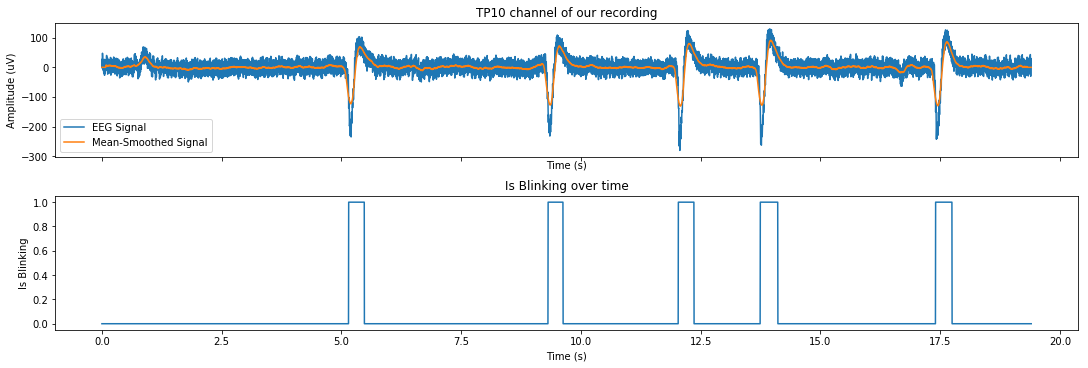

In [81]:
fig, axes = plt.subplots(2, 1, constrained_layout=True, sharex=True, figsize=[15,5])

# Plot the TP10 channel
axes[0].set_title('TP10 channel of our recording')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude (uV)')
axes[0].plot(eeg_data['timestamps'], eeg_data[CHANNEL], label="EEG Signal")
axes[0].plot(eeg_data['timestamps'], filtered_signal, label="Mean-Smoothed Signal")
axes[0].legend()

# Plot the blink data
axes[1].set_title('Is Blinking over time')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Is Blinking')
axes[1].plot(eeg_data['timestamps'], debounced_blink_signal)

We can see two issues with what we just done. First, the mean-smoothed signal, does not follow the eye blink curve correctly. It could be corrected by decreasing the K value, but it would result in a less smoothed signal. It seems like a Gaussian-smoothing filter would be more appropriate because it weights the data point's neighbours more than the further points. It would result in a well smoothed signal that follows the spikes of the eye blinks. Nevertheless, we will continue with this method just to see the result.

Another problem (which can be adressed right now), is that the is_blinking detections are not large enough to cover the full eye blink spikes. We will need to apply a factor on the [duty cycle](https://en.wikipedia.org/wiki/Duty_cycle) of this signal.

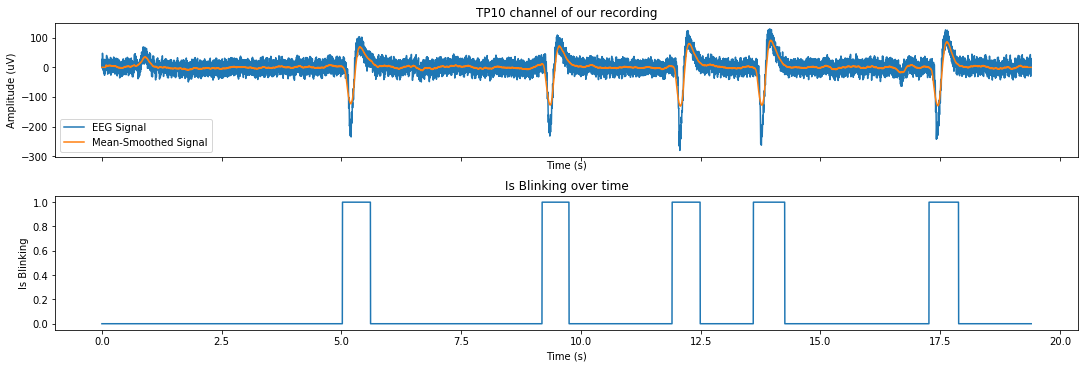

In [82]:
SCALE_FACTOR = 1.8
debounced_blink_signal = scale_duty_cycle(debounced_blink_signal, SCALE_FACTOR)

fig, axes = plt.subplots(2, 1, constrained_layout=True, sharex=True, figsize=[15,5])

# Plot the TP10 channel
axes[0].set_title('TP10 channel of our recording')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude (uV)')
axes[0].plot(eeg_data['timestamps'], eeg_data[CHANNEL], label="EEG Signal")
axes[0].plot(eeg_data['timestamps'], filtered_signal, label="Mean-Smoothed Signal")
axes[0].legend()

# Plot the blink data
axes[1].set_title('Is Blinking over time')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Is Blinking')
axes[1].plot(eeg_data['timestamps'], debounced_blink_signal)

The last step is to remove the smoothed signal (that represents the artefact signal) from the EEG signal.

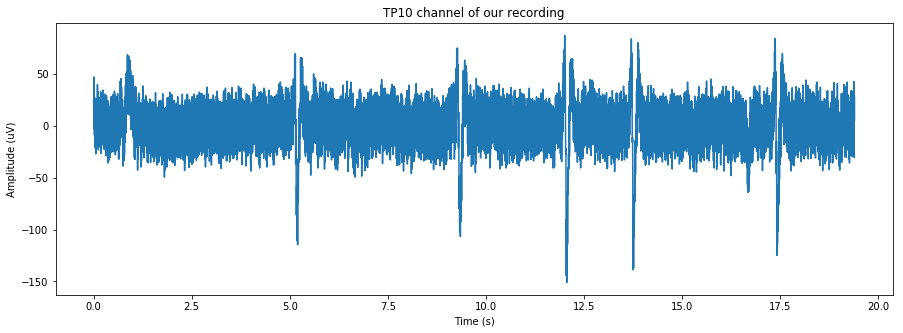

In [83]:
filtered_domain = [index for index, is_blinking in enumerate(debounced_blink_signal) if is_blinking]
filtered_eeg_data = deepcopy(eeg_data[CHANNEL])
for i in filtered_domain:
    filtered_eeg_data[i] -= filtered_signal[i]

# Plot the TP10 channel
plt.figure(figsize=(15,5))
plt.title('TP10 channel of our recording')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.plot(eeg_data['timestamps'], filtered_eeg_data)

We got a signal that still contain relatively huge spikes. This is mainly caused by the fact that our mean-smoothing filter did not follow the spike. When we did substract the artefact signal from the EEG signal, it resulted in these spikes. Let's see if the Gaussian smoothing filter will do better.

### Gaussian-smoothing filter
We will do the same as before but with the Gaussian-smoothing filter. This filter is the same as the mean-smoothing filter but use a weighted mean by a gaussian distribution.

1. Fix the gaussian distribution with [FWHM](https://en.wikipedia.org/wiki/Full_width_at_half_maximum)


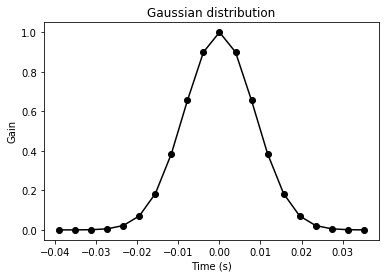

In [87]:
FWHM = 0.02 # full width at half maximum in seconds. Must be small to ensure that we follow the eye blink curves
K = 10

gaussian_time_window = np.arange(-K,K)/FREQUENCY
gaussian_window = np.exp(-(4*np.log(2)*gaussian_time_window**2)/FWHM**2)

plt.title('Gaussian distribution')
plt.xlabel('Time (s)')
plt.ylabel('Gain')
plt.plot(gaussian_time_window,gaussian_window,'ko-')

We chose a small full width at half maximum so the smoothing can be really local. It will increase the capacity of the filtered signal to follow the huge curves of the eye blinks. Of course, it makes the smoothed signal more sensible to every local variations in the signal, but since we're only applying this filter to the eye blinks artefacts, it should not be a real issue.

In [88]:
# Normalize the gaussian to keep the scale
normalized_gaussian_window = gaussian_window / np.sum(gaussian_window)

filtered_signal = np.zeros(N)
for i in range(K+1, N-K-1):
    filtered_signal[i] = np.sum(eeg_data[CHANNEL][i-K:i+K]*normalized_gaussian_window)

Let's plot the result!

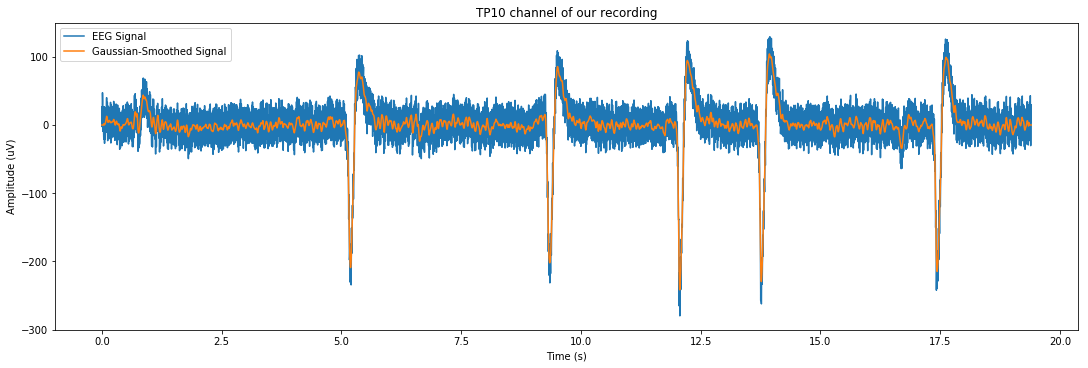

In [89]:
fig, axes = plt.subplots(1, 1, constrained_layout=True, sharex=True, figsize=[15,5])

# Plot the TP10 channel
axes.set_title('TP10 channel of our recording')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude (uV)')
axes.plot(eeg_data['timestamps'], eeg_data[CHANNEL], label="EEG Signal")
axes.plot(eeg_data['timestamps'], filtered_signal, label="Gaussian-Smoothed Signal")
axes.legend()

Finally, let's filter our signal.

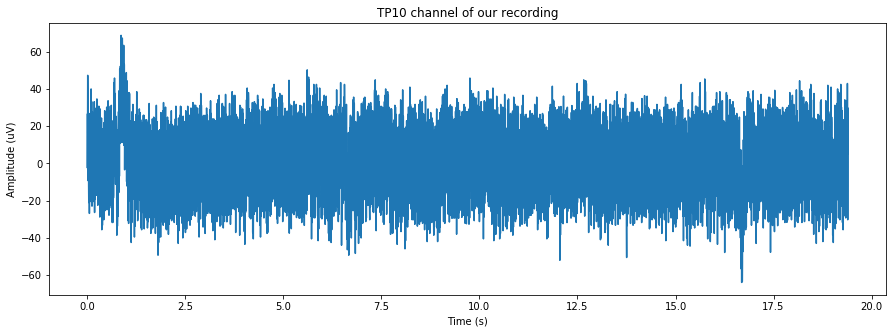

In [90]:
filtered_domain = [index for index, is_blinking in enumerate(debounced_blink_signal) if is_blinking]
filtered_eeg_data = deepcopy(eeg_data[CHANNEL])
for i in filtered_domain:
    filtered_eeg_data[i] -= filtered_signal[i]

# Plot the TP10 channel
plt.figure(figsize=(15,5))
plt.title('TP10 channel of our recording')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.plot(eeg_data['timestamps'], filtered_eeg_data)

Finally, it seems like the gaussian filter really was a better alternative to the mean-smoothing filter.

We could also have used the two following ways to filter these artefacts:
1. By finding a polynomial that fits the signal distribution for every eye blink. Then we could remove that modelization of the eye blink from the original signal.
2. Use a finite impulse response filter to remove the eye blinks frequency